## Importing Packages

In [1]:
using CSV, DataFrames, PyCall, GLM, MLBase, Combinatorics

In [60]:
using Plots, StatsPlots, Plots.PlotMeasures
pyplot();

In [3]:
@pyimport statsmodels.stats.outliers_influence as vif
@pyimport sklearn.model_selection as sk
@pyimport imblearn
@pyimport statsmodels.api as sm

## The data

In [4]:
brca = CSV.read("brca_df.csv", DataFrame, normalizenames= true);
first(brca,5)

Row,Age,Gender,Protein1,Protein2,Protein3,Protein4,HER2_status,II,I,Infiltrating_Ductal_Carcinoma,Infiltrating_Lobular_Carcinoma,Modified_Radical_Mastectomy,Lumpectomy,Simple_Mastectomy,Patient_Status
,Int64,Int64,Float64,Float64,Float64,Float64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64
1,36,0,0.080353,0.42638,0.54715,0.27368,0,0,0,1,0,1,0,0,1
2,43,0,-0.42032,0.57807,0.61447,-0.031505,0,1,0,0,0,0,1,0,0
3,69,0,0.21398,1.3114,-0.32747,-0.23426,0,0,0,1,0,0,0,0,1
4,56,0,0.34509,-0.21147,-0.19304,0.12427,0,1,0,1,0,1,0,0,1
5,56,0,0.22155,1.9068,0.52045,-0.31199,0,1,0,1,0,0,0,0,0


In [5]:
describe(brca)

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float64,Real,Float64,Real,Int64,DataType
1,Age,58.7256,29,58.0,90,0,Int64
2,Gender,0.0126183,0,0.0,1,0,Int64
3,Protein1,-0.0272321,-2.1446,0.0056486,1.5936,0,Float64
4,Protein2,0.949557,-0.97873,0.99713,3.4022,0,Float64
5,Protein3,-0.095104,-1.6274,-0.19304,2.1934,0,Float64
6,Protein4,0.00671301,-2.0255,0.038522,1.6299,0,Float64
7,HER2_status,0.0914826,0,0.0,1,0,Int64
8,II,0.567823,0,1.0,1,0,Int64
9,I,0.189274,0,0.0,1,0,Int64


## Basic Logistic Regression

In [6]:
fm = @formula(Patient_Status ~ Age + Gender + Protein1 + Protein2 + Protein3 + Protein4 + HER2_status + I + II + 
                                Infiltrating_Lobular_Carcinoma + Infiltrating_Ductal_Carcinoma + 
                                Modified_Radical_Mastectomy + Lumpectomy + Simple_Mastectomy);
logit = glm(fm, brca, Binomial(), ProbitLink())

StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Vector{Float64}, Binomial{Float64}, ProbitLink}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

Patient_Status ~ 1 + Age + Gender + Protein1 + Protein2 + Protein3 + Protein4 + HER2_status + I + II + Infiltrating_Lobular_Carcinoma + Infiltrating_Ductal_Carcinoma + Modified_Radical_Mastectomy + Lumpectomy + Simple_Mastectomy

Coefficients:
──────────────────────────────────────────────────────────────────────────────────────────────
                                     Coef.  Std. Error      z  Pr(>|z|)   Lower 95%  Upper 95%
──────────────────────────────────────────────────────────────────────────────────────────────
(Intercept)                      0.238205   0.60928      0.39    0.6958  -0.955963   1.43237
Age                              0.0015643  0.00670538   0.23    0.8155  -0.011578   0.0147066
Gender                          -0.316648   0.7

In [7]:
prediction = GLM.predict(logit,brca);
prediction = [if x < 0.5 0 else 1 end for x in prediction]
confmat = MLBase.roc(brca.Patient_Status, prediction);
[:ConfMat :PredictedAlive :PredictedDead; :ActualAlive confmat.tp confmat.fn; :ActualDead confmat.fp confmat.tn]

3×3 Matrix{Any}:
 :ConfMat         :PredictedAlive   :PredictedDead
 :ActualAlive  255                 0
 :ActualDead    62                 0

In [8]:
println("Overall Accuracy: ",round((confmat.tp + confmat.tn)*100/length(prediction), digits = 2),"%")
println("AIC= ",MLBase.aic(logit))
println("BIC= ",MLBase.bic(logit))
println("Recall= ",MLBase.recall(confmat))
println("Specificity= ",MLBase.true_negative_rate(confmat))
println("Fall-out= ",MLBase.false_positive_rate(confmat))
println("Precision= ",MLBase.precision(confmat))

Overall Accuracy: 80.44%
AIC= 331.6236426365257
BIC= 388.00716924468486
Recall= 1.0
Specificity= 0.0
Fall-out= 1.0
Precision= 0.804416403785489


In [9]:
recall_1 = []
fallout_1 = []
for t in range(start=0,step=0.005, stop=1)
    r_val = []
    f_val = []
    for i in 1:100
    fm = @formula(Patient_Status ~ Age + Gender + Protein1 + Protein2 + Protein3 + Protein4 + HER2_status + I + II + 
                                Infiltrating_Lobular_Carcinoma + Infiltrating_Ductal_Carcinoma + 
                                Modified_Radical_Mastectomy + Lumpectomy + Simple_Mastectomy);
    logit = glm(fm, brca, Binomial(), ProbitLink())

    prediction = GLM.predict(logit,brca);
    prediction = [if x < t 0 else 1 end for x in prediction]
    confmat = MLBase.roc(brca.Patient_Status, prediction);
    push!(r_val,MLBase.recall(confmat))
    push!(f_val,MLBase.false_positive_rate(confmat))
    end
push!(recall_1,mean(r_val))
push!(fallout_1,mean(f_val))
end

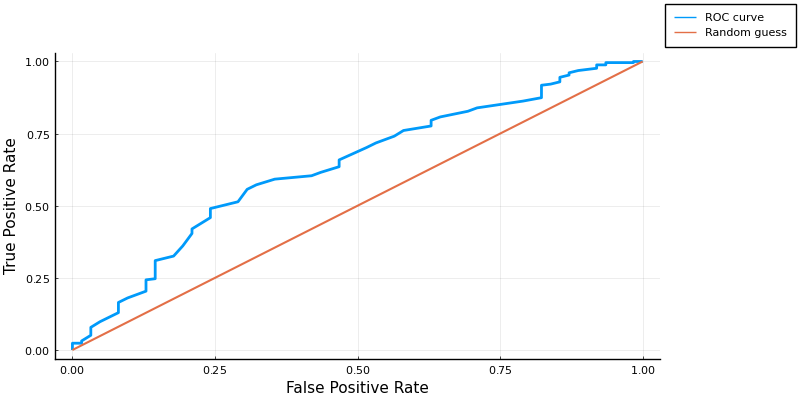

In [10]:
plot(fallout_1,recall_1, legendposition=:outertopright, label = "ROC curve", lw = 2)
plot!(0:0.005:1,0:0.005:1, label = "Random guess", size = (800,400), lw = 1.5, xlabel = "False Positive Rate",
        ylabel = "True Positive Rate")

In [11]:
vif_data = DataFrame(Predictors = names(brca),
    VIF = [vif.variance_inflation_factor(Array(brca), i) for i in 0: size(brca)[2]-1])

Row,Predictors,VIF
,String,Float64
1,Age,16.0918
2,Gender,1.06151
3,Protein1,1.22344
4,Protein2,2.66677
5,Protein3,1.27453
6,Protein4,1.12297
7,HER2_status,1.15197
8,II,3.4601
9,I,1.99962


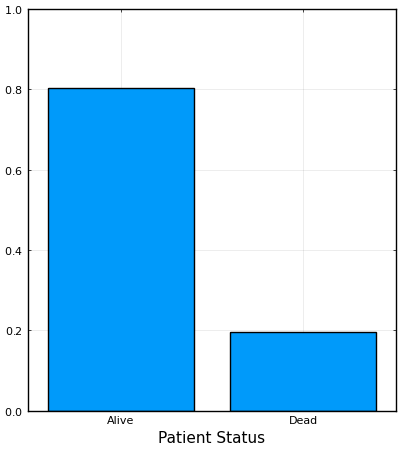

sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


In [12]:
l = []
for j in unique(brca.Patient_Status)
    push!(l,length([brca.Patient_Status[i] for i in 1:length(brca.Patient_Status) if brca.Patient_Status[i]==j])/length(brca.Patient_Status))
end
l = [Float64(x) for x in l];
bar(["Alive", "Dead"], l, ylim = (0,1), framestyle = :box, legend = false, size = (400,450), xlabel = "Patient Status")

## Class Imbalance

In [13]:
smote = imblearn.over_sampling.SMOTE();

In [14]:
X = Array(brca[:,1:14]);
y = brca[:,:Patient_Status];

In [15]:
X, y = smote.fit_resample(X, y);

In [16]:
brca = DataFrame(X, ["Age", "Gender", "Protein1", "Protein2", "Protein3", "Protein4", "HER2_status", "II", "I", 
                    "Infiltrating_Ductal_Carcinoma", "Infiltrating_Lobular_Carcinoma", "Modified_Radical_Mastectomy", 
                    "Lumpectomy", "Simple_Mastectomy"]);
insertcols!(brca, 15, :Patient_Status => y);

In [17]:
size(brca)

(510, 15)

In [18]:
describe(brca)

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float64,Real,Float64,Real,Int64,DataType
1,Age,58.5752,29.0,58.0,90.0,0,Float64
2,Gender,0.00937718,0.0,0.0,1.0,0,Float64
3,Protein1,-0.042976,-2.1446,-0.000633585,1.5936,0,Float64
4,Protein2,1.01944,-0.97873,1.05337,3.4022,0,Float64
5,Protein3,-0.0840826,-1.6274,-0.157058,2.1934,0,Float64
6,Protein4,0.0638612,-2.0255,0.113585,1.6299,0,Float64
7,HER2_status,0.0741126,0.0,0.0,1.0,0,Float64
8,II,0.562745,0.0,0.897883,1.0,0,Float64
9,I,0.156552,0.0,0.0,1.0,0,Float64


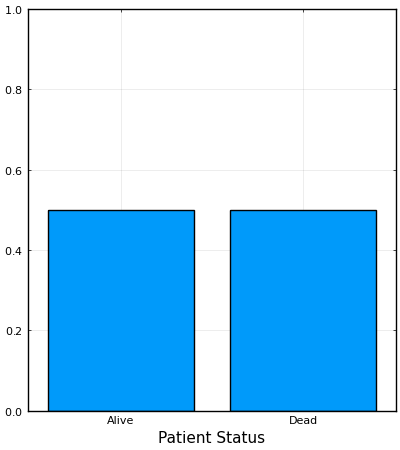

sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


In [19]:
l = []
for j in unique(brca.Patient_Status)
    push!(l,length([brca.Patient_Status[i] for i in 1:length(brca.Patient_Status) if brca.Patient_Status[i]==j])/length(brca.Patient_Status))
end
l = [Float64(x) for x in l];
bar(["Alive", "Dead"], l, ylim = (0,1), framestyle = :box, legend = false, size = (400,450), xlabel = "Patient Status")

## SMOTE Logistic Regression

In [20]:
fm = @formula(Patient_Status ~ Age + Gender + Protein1 + Protein2 + Protein3 + Protein4 + HER2_status + I + II + 
                                Infiltrating_Lobular_Carcinoma + Infiltrating_Ductal_Carcinoma + 
                                Modified_Radical_Mastectomy + Lumpectomy + Simple_Mastectomy);
logit = glm(fm, brca, Binomial(), ProbitLink())

StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Vector{Float64}, Binomial{Float64}, ProbitLink}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

Patient_Status ~ 1 + Age + Gender + Protein1 + Protein2 + Protein3 + Protein4 + HER2_status + I + II + Infiltrating_Lobular_Carcinoma + Infiltrating_Ductal_Carcinoma + Modified_Radical_Mastectomy + Lumpectomy + Simple_Mastectomy

Coefficients:
───────────────────────────────────────────────────────────────────────────────────────────────────
                                       Coef.  Std. Error      z  Pr(>|z|)    Lower 95%    Upper 95%
───────────────────────────────────────────────────────────────────────────────────────────────────
(Intercept)                     -1.00642      0.44115     -2.28    0.0225  -1.87106     -0.141783
Age                             -0.000349232  0.00494117  -0.07    0.9437  -0.0100337    0.00933528
Gender                

In [21]:
prediction = GLM.predict(logit,brca);
prediction = [if x < 0.5 0 else 1 end for x in prediction]
confmat = MLBase.roc(brca.Patient_Status, prediction);
[:ConfMat :PredictedAlive :PredictedDead; :ActualAlive confmat.tp confmat.fn; :ActualDead confmat.fp confmat.tn]

3×3 Matrix{Any}:
 :ConfMat         :PredictedAlive     :PredictedDead
 :ActualAlive  151                 104
 :ActualDead    74                 181

In [22]:
println("Overall Accuracy: ",round((confmat.tp + confmat.tn)*100/length(prediction), digits = 2),"%")
println("AIC= ",MLBase.aic(logit))
println("BIC= ",MLBase.bic(logit))
println("Recall= ",MLBase.recall(confmat))
println("Specificity= ",MLBase.true_negative_rate(confmat))
println("Fall-out= ",MLBase.false_positive_rate(confmat))
println("Precision= ",MLBase.precision(confmat))

Overall Accuracy: 65.1%
AIC= 681.8420476777326
BIC= 745.3582085635081
Recall= 0.592156862745098
Specificity= 0.7098039215686275
Fall-out= 0.2901960784313726
Precision= 0.6711111111111111


In [23]:
recall_2 = []
fallout_2 = []
for t in range(start=0,step=0.005, stop=1)
    r_val = []
    f_val = []
    for i in 1:100
        fm = @formula(Patient_Status ~ Age + Gender + Protein1 + Protein2 + Protein3 + Protein4 + HER2_status + I + II + 
                                    Infiltrating_Lobular_Carcinoma + Infiltrating_Ductal_Carcinoma + 
                                    Modified_Radical_Mastectomy + Lumpectomy + Simple_Mastectomy);
        logit = glm(fm, brca, Binomial(), ProbitLink())

        prediction = GLM.predict(logit,brca);
        prediction = [if x < t 0 else 1 end for x in prediction]
        confmat = MLBase.roc(brca.Patient_Status, prediction);
        push!(r_val,MLBase.recall(confmat))
        push!(f_val,MLBase.false_positive_rate(confmat))
        end
push!(recall_2,mean(r_val))
push!(fallout_2,mean(f_val))
end

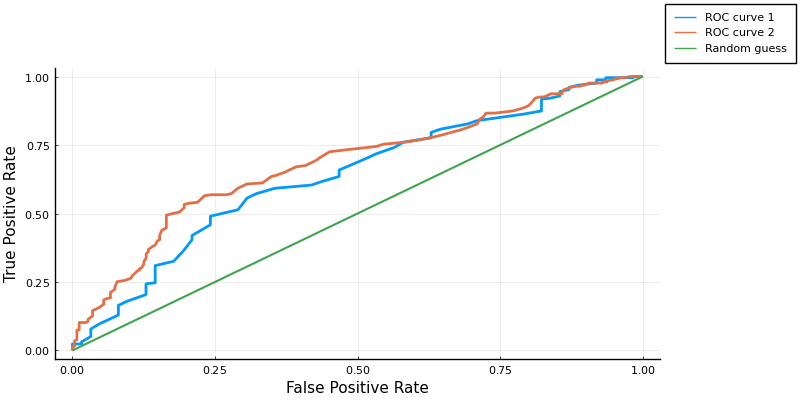

In [24]:
plot(fallout_1,recall_1, legendposition=:outertopright, label = "ROC curve 1", lw = 2)
plot!(fallout_2,recall_2, legendposition=:outertopright, label = "ROC curve 2", lw = 2)
plot!(0:0.005:1,0:0.005:1, label = "Random guess", size = (800,400), lw = 1.5, xlabel = "False Positive Rate",
        ylabel = "True Positive Rate")

In [25]:
vif_data = DataFrame(Predictors = names(brca),
    VIF = [vif.variance_inflation_factor(Array(brca), i) for i in 0: size(brca)[2]-1])

Row,Predictors,VIF
,String,Float64
1,Age,17.8824
2,Gender,1.04718
3,Protein1,1.23756
4,Protein2,3.05399
5,Protein3,1.2034
6,Protein4,1.16789
7,HER2_status,1.14216
8,II,3.57952
9,I,1.88126


## Best Subset Selection

In [26]:
function best_subset_selection(df)
    dev = []
    for num in 1:length(names(df))-1
        val = []
        for i in collect(combinations(1:length(names(df))-1,num))
            logreg = glm(Array(df[:,i]), Array(df[:,15]), Binomial(), ProbitLink())
            push!(val,MLBase.deviance(logreg))
        end
        push!(dev,collect(combinations(1:length(names(df))-1,num))[indexin(minimum(val),val)])
    end
    return [dev[i][1] for i in 1:length(names(df))-1]
end

best_subset_selection (generic function with 1 method)

In [27]:
dev = best_subset_selection(brca)

14-element Vector{Vector{Int64}}:
 [6]
 [6, 9]
 [4, 6, 9]
 [4, 6, 9, 13]
 [3, 4, 6, 7, 9]
 [3, 4, 6, 7, 8, 9]
 [3, 4, 6, 7, 8, 9, 13]
 [3, 4, 6, 7, 8, 9, 11, 13]
 [3, 4, 5, 6, 7, 8, 9, 11, 13]
 [3, 4, 5, 6, 7, 8, 9, 11, 13, 14]
 [1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13]
 [1, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14]
 [1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

In [28]:
final = []
for d in dev
    logreg = glm(Array(brca[:,d]), Array(brca[:,15]), Binomial(), ProbitLink())
    push!(final,MLBase.aic(logreg))
end
println("Indices of the 'best' model are ",dev[indexin(minimum(final),final)[1]])
println("The predictors to the corresponding indices are\n",names(brca[:,dev[indexin(minimum(final),final)[1]]]))

Indices of the 'best' model are [3, 4, 6, 7, 8, 9, 13]
The predictors to the corresponding indices are
["Protein1", "Protein2", "Protein4", "HER2_status", "II", "I", "Lumpectomy"]


## Forward Step-wise Selection

In [29]:
function forward_stepwise_selection(df)
    dev = []
    comb = collect(combinations(1:length(names(df))-1,1))
    for num in 1:length(names(df))-1
        val = []
        for j in comb
            logreg = glm(Array(df[:,j]), Array(df[:,15]), Binomial(), ProbitLink())
            push!(val,MLBase.deviance(logreg))
        end
        push!(dev,comb[indexin(minimum(val),val)])
        comb = collect(combinations(1:length(names(df))-1,num+1)) 
        l = []
        for j in 1:length(comb)
            a = true
            for i in dev[end][1]
                a = a & (i in comb[j])
            end
        push!(l,a)
        end
        comb = comb[[i for i in l]]
    end
    return [dev[i][1] for i in 1:length(names(df))-1]
end

forward_stepwise_selection (generic function with 1 method)

In [30]:
dev = forward_stepwise_selection(brca)

14-element Vector{Vector{Int64}}:
 [6]
 [6, 9]
 [4, 6, 9]
 [4, 6, 9, 13]
 [3, 4, 6, 9, 13]
 [3, 4, 6, 7, 9, 13]
 [3, 4, 6, 7, 8, 9, 13]
 [3, 4, 6, 7, 8, 9, 11, 13]
 [3, 4, 5, 6, 7, 8, 9, 11, 13]
 [3, 4, 5, 6, 7, 8, 9, 11, 13, 14]
 [3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14]
 [1, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14]
 [1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

In [31]:
final = []
for d in dev
    logreg = glm(Array(brca[:,d]), Array(brca[:,15]), Binomial(), ProbitLink())
    push!(final,MLBase.aic(logreg))
end
println("Indices of the 'best' model are ",dev[indexin(minimum(final),final)[1]])
println("The predictors to the corresponding indices are\n",names(brca[:,dev[indexin(minimum(final),final)[1]]]))

Indices of the 'best' model are [3, 4, 6, 7, 8, 9, 13]
The predictors to the corresponding indices are
["Protein1", "Protein2", "Protein4", "HER2_status", "II", "I", "Lumpectomy"]


## Backward Step-wise Selection

In [32]:
function backward_stepwise_selection(df)
    dev = [[s for s in 1:length(names(df))-1]]
    comb = collect(combinations(dev[1],length(names(df))-2))
    while length(dev[end])!=1
        val = []
        for j in comb
            logreg = glm(Array(df[:,j]), Array(df[:,15]), Binomial(), ProbitLink())
            push!(val,MLBase.deviance(logreg))
        end
        push!(dev,comb[indexin(minimum(val),val)][1])
        comb = collect(combinations(dev[end],length(dev[end])-1))
    end
    return dev
end

backward_stepwise_selection (generic function with 1 method)

In [33]:
dev = backward_stepwise_selection(brca)

14-element Vector{Vector{Int64}}:
 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
 [1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
 [1, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14]
 [1, 3, 4, 6, 7, 8, 9, 11, 12, 13, 14]
 [1, 3, 4, 6, 7, 8, 9, 11, 13, 14]
 [3, 4, 6, 7, 8, 9, 11, 13, 14]
 [3, 4, 6, 7, 8, 9, 11, 13]
 [3, 4, 6, 7, 8, 9, 13]
 [3, 4, 6, 7, 8, 9]
 [3, 4, 6, 7, 9]
 [4, 6, 7, 9]
 [4, 6, 9]
 [6, 9]
 [6]

In [34]:
final = []
for d in dev
    logreg = glm(Array(brca[:,d]), Array(brca[:,15]), Binomial(), ProbitLink())
    push!(final,MLBase.aic(logreg))
end
println("Indices of the 'best' model are ",dev[indexin(minimum(final),final)[1]])
println("The predictors to the corresponding indices are\n",names(brca[:,dev[indexin(minimum(final),final)[1]]]))

Indices of the 'best' model are [3, 4, 6, 7, 8, 9, 13]
The predictors to the corresponding indices are
["Protein1", "Protein2", "Protein4", "HER2_status", "II", "I", "Lumpectomy"]


## AUC Calculation

In [35]:
function auc(fallout,recall)
    integral = 0
    f = [i for i in keys(sort(Dict([(fallout[i],recall[i]) for i in 1:length(fallout)])))]
    r = [i for i in values(sort(Dict([(fallout[i],recall[i]) for i in 1:length(fallout)])))];
    for i in 1:length(f)-1
        integral = integral + 0.5*(r[i+1]+r[i])*(f[i+1]-f[i])
    end
    return integral
end

auc (generic function with 1 method)

## Further Assessment

In [36]:
names(brca[:,[3,4,6,9,11,12,13,14]])

8-element Vector{String}:
 "Protein1"
 "Protein2"
 "Protein4"
 "I"
 "Infiltrating_Lobular_Carcinoma"
 "Modified_Radical_Mastectomy"
 "Lumpectomy"
 "Simple_Mastectomy"

In [37]:
fm = @formula(Patient_Status ~ Protein1+Protein2+Protein4+I+Modified_Radical_Mastectomy+Lumpectomy+Simple_Mastectomy);
logit = glm(fm, brca, Binomial(), ProbitLink())

StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Vector{Float64}, Binomial{Float64}, ProbitLink}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

Patient_Status ~ 1 + Protein1 + Protein2 + Protein4 + I + Modified_Radical_Mastectomy + Lumpectomy + Simple_Mastectomy

Coefficients:
────────────────────────────────────────────────────────────────────────────────────────────
                                  Coef.  Std. Error      z  Pr(>|z|)   Lower 95%   Upper 95%
────────────────────────────────────────────────────────────────────────────────────────────
(Intercept)                  -0.0298946   0.133982   -0.22    0.8234  -0.292495    0.232706
Protein1                      0.259457    0.125854    2.06    0.0392   0.0127869   0.506126
Protein2                     -0.194729    0.0706292  -2.76    0.0058  -0.333159   -0.0562978
Protein4                     -0.357174    0.102838   -3.47    0.0005  -0.5

In [38]:
prediction = GLM.predict(logit,brca);
prediction = [if x < 0.5 0 else 1 end for x in prediction]
confmat = MLBase.roc(brca.Patient_Status, prediction);
[:ConfMat :PredictedAlive :PredictedDead; :ActualAlive confmat.tp confmat.fn; :ActualDead confmat.fp confmat.tn]

3×3 Matrix{Any}:
 :ConfMat         :PredictedAlive     :PredictedDead
 :ActualAlive  148                 107
 :ActualDead    87                 168

In [39]:
println("Overall Accuracy: ",round((confmat.tp + confmat.tn)*100/length(prediction), digits = 2),"%")
println("AIC= ",MLBase.aic(logit))
println("BIC= ",MLBase.bic(logit))
println("Recall= ",MLBase.recall(confmat))
println("Specificity= ",MLBase.true_negative_rate(confmat))
println("Fall-out= ",MLBase.false_positive_rate(confmat))
println("Precision= ",MLBase.precision(confmat))

Overall Accuracy: 61.96%
AIC= 685.0499412383539
BIC= 718.9252270441009
Recall= 0.5803921568627451
Specificity= 0.6588235294117647
Fall-out= 0.3411764705882353
Precision= 0.6297872340425532


In [40]:
fm = @formula(Patient_Status ~ Protein1+Protein2+Protein4+I+Modified_Radical_Mastectomy+Lumpectomy);
logit = glm(fm, brca, Binomial(), ProbitLink())

StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Vector{Float64}, Binomial{Float64}, ProbitLink}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

Patient_Status ~ 1 + Protein1 + Protein2 + Protein4 + I + Modified_Radical_Mastectomy + Lumpectomy

Coefficients:
────────────────────────────────────────────────────────────────────────────────────────────
                                  Coef.  Std. Error      z  Pr(>|z|)   Lower 95%   Upper 95%
────────────────────────────────────────────────────────────────────────────────────────────
(Intercept)                   0.0946485   0.114175    0.83    0.4071  -0.129131    0.318428
Protein1                      0.291958    0.124432    2.35    0.0190   0.0480751   0.535841
Protein2                     -0.205659    0.0703639  -2.92    0.0035  -0.343569   -0.0677479
Protein4                     -0.357654    0.102624   -3.49    0.0005  -0.558793   -0.156515
I 

In [41]:
prediction = GLM.predict(logit,brca);
prediction = [if x < 0.5 0 else 1 end for x in prediction]
confmat = MLBase.roc(brca.Patient_Status, prediction);
[:ConfMat :PredictedAlive :PredictedDead; :ActualAlive confmat.tp confmat.fn; :ActualDead confmat.fp confmat.tn]

3×3 Matrix{Any}:
 :ConfMat         :PredictedAlive     :PredictedDead
 :ActualAlive  143                 112
 :ActualDead    73                 182

In [42]:
println("Overall Accuracy: ",round((confmat.tp + confmat.tn)*100/length(prediction), digits = 2),"%")
println("AIC= ",MLBase.aic(logit))
println("BIC= ",MLBase.bic(logit))
println("Recall= ",MLBase.recall(confmat))
println("Specificity= ",MLBase.true_negative_rate(confmat))
println("Fall-out= ",MLBase.false_positive_rate(confmat))
println("Precision= ",MLBase.precision(confmat))

Overall Accuracy: 63.73%
AIC= 686.218464396751
BIC= 715.8593394767796
Recall= 0.5607843137254902
Specificity= 0.7137254901960784
Fall-out= 0.28627450980392155
Precision= 0.6620370370370371


In [43]:
recall_4 = []
fallout_4 = []
for t in range(start=0,step=0.005, stop=1)
    r_val = []
    f_val = []
    for i in 1:100
    fm = @formula(Patient_Status ~ Protein1+Protein2+Protein4+I+Lumpectomy+Modified_Radical_Mastectomy);
    logit = glm(fm, brca, Binomial(), ProbitLink())

    prediction = GLM.predict(logit,brca);
    prediction = [if x < t 0 else 1 end for x in prediction]
    confmat = MLBase.roc(brca.Patient_Status, prediction);
    push!(r_val,MLBase.recall(confmat))
    push!(f_val,MLBase.false_positive_rate(confmat))
    end
push!(recall_4,mean(r_val))
push!(fallout_4,mean(f_val))
end

In [44]:
recall_5 = []
fallout_5 = []
for t in range(start=0,step=0.005, stop=1)
    r_val = []
    f_val = []
    for i in 1:100
    fm = @formula(Patient_Status ~ Protein1+Protein2+Protein4+I+Lumpectomy+Modified_Radical_Mastectomy+Simple_Mastectomy);
    logit = glm(fm, brca, Binomial(), ProbitLink())

    prediction = GLM.predict(logit,brca);
    prediction = [if x < t 0 else 1 end for x in prediction]
    confmat = MLBase.roc(brca.Patient_Status, prediction);
    push!(r_val,MLBase.recall(confmat))
    push!(f_val,MLBase.false_positive_rate(confmat))
    end
push!(recall_5,mean(r_val))
push!(fallout_5,mean(f_val))
end

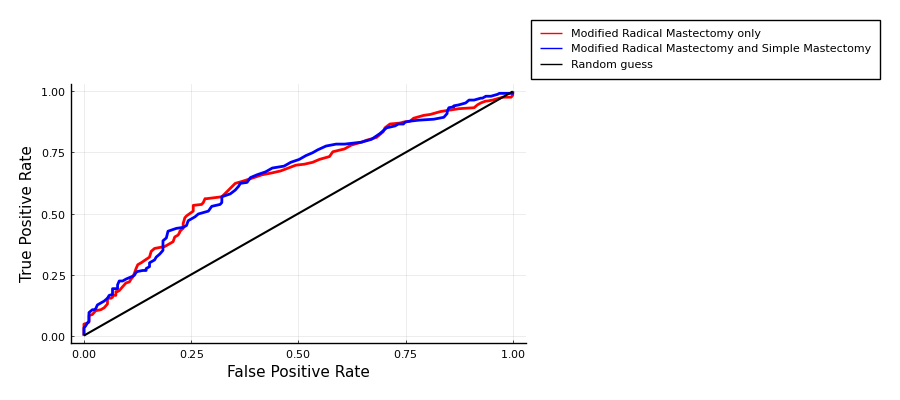

In [45]:
plot(fallout_4,recall_4, label = "Modified Radical Mastectomy only", lw = 2, c="red")
plot!(fallout_5,recall_5, label = "Modified Radical Mastectomy and Simple Mastectomy", lw = 2, c="blue")
plot!(0:0.005:1,0:0.005:1, label = "Random guess", size = (900,400), lw = 1.5, xlabel = "False Positive Rate",
        ylabel = "True Positive Rate", c="black", legendposition=:outertopright, margin = 5mm)

In [46]:
auc(fallout_4,recall_4)

0.6492349096501344

In [47]:
auc(fallout_5,recall_5)

0.6527643214148408

## ROC

In [48]:
recall_3 = []
fallout_3 = []
for t in range(start=0,step=0.005, stop=1)
    r_val = []
    f_val = []
    for i in 1:100
    fm = @formula(Patient_Status ~ Protein1+Protein2+Protein4+I+Modified_Radical_Mastectomy+Lumpectomy+Simple_Mastectomy);
    logit = glm(fm, brca, Binomial(), ProbitLink())

    prediction = GLM.predict(logit,brca);
    prediction = [if x < t 0 else 1 end for x in prediction]
    confmat = MLBase.roc(brca.Patient_Status, prediction);
    push!(r_val,MLBase.recall(confmat))
    push!(f_val,MLBase.false_positive_rate(confmat))
    end
push!(recall_3,mean(r_val))
push!(fallout_3,mean(f_val))
end

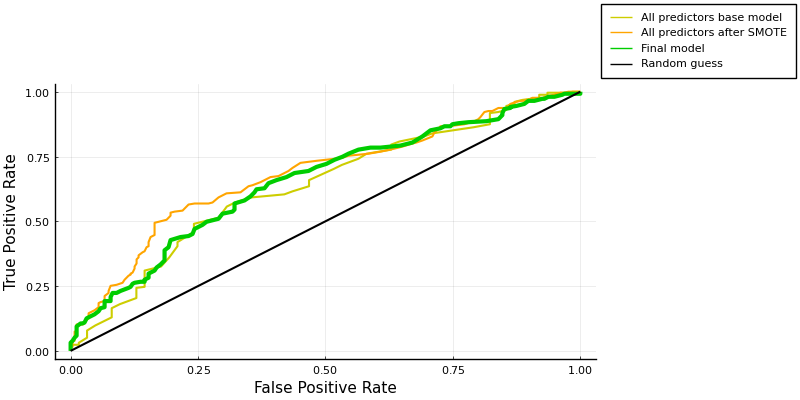

In [49]:
plot(fallout_1,recall_1, legendposition=:outertopright, label = "All predictors base model", lw = 1.5, c="yellow3")
plot!(fallout_2,recall_2, legendposition=:outertopright, label = "All predictors after SMOTE", lw = 1.5, c="orange")
plot!(fallout_3,recall_3, legendposition=:outertopright, label = "Final model", lw = 3, c="green3")
plot!(0:0.005:1,0:0.005:1, label = "Random guess", size = (800,400), lw = 1.5, xlabel = "False Positive Rate",
        ylabel = "True Positive Rate", c="black")

In [50]:
auc(fallout_1,recall_1)

0.6322264389626815

In [51]:
auc(fallout_2,recall_2)

0.6806382160707422

In [52]:
auc(fallout_3,recall_3)

0.6527643214148408

## VIF

In [53]:
vif_data = DataFrame(Predictors =
    ["Protein1","Protein2","Protein4","I","Lumpectomy","Modified_Radical_Mastectomy","Simple_Mastectomy"],
    VIF = [vif.variance_inflation_factor(Array(brca[:,[3,4,6,9,13,12,14]]), i)
        for i in 0: size(brca[:,[3,4,6,9,13,12,14]])[2]-1])

Row,Predictors,VIF
,String,Float64
1,Protein1,1.0867
2,Protein2,1.64915
3,Protein4,1.08862
4,I,1.21255
5,Lumpectomy,1.28881
6,Modified_Radical_Mastectomy,1.24393
7,Simple_Mastectomy,1.21162


## K-fold

In [54]:
function kfold(brca,k)
    train = collect(Kfold(size(brca)[1],k))
    test = []
    cv = []
    for i in 1:k
        push!(test,sort(collect(setdiff(Set(1:size(brca)[1]), train[i]))))
    end
    for i in 1:k
        X_train, X_test, y_train, y_test = Array(brca[train[i],[3,4,6,9,12,13,14]]), Array(brca[test[i],[3,4,6,9,12,13,14]]),
                                        Array(brca[train[i],15]), Array(brca[test[i],15]);

        brca_train = DataFrame(Protein1 = X_train[:,1], Protein2 = X_train[:,:2], Protein4 = X_train[:,:3], I = X_train[:,:4], 
            Modified_Radical_Mastectomy = X_train[:,:5], Lumpectomy = X_train[:,:6], Simple_Mastectomy = X_train[:,:7],Patient_Status = y_train);

        brca_test = DataFrame(Protein1 = X_test[:,1], Protein2 = X_test[:,:2], Protein4 = X_test[:,:3], I = X_test[:,:4], 
            Modified_Radical_Mastectomy = X_test[:,:5], Lumpectomy = X_test[:,:6], Simple_Mastectomy = X_test[:,:7],Patient_Status = y_test);

        fm = @formula(Patient_Status ~ Protein1+Protein2+Protein4+I+Modified_Radical_Mastectomy+Lumpectomy+Simple_Mastectomy);
        logit = glm(fm, brca_train, Binomial(), ProbitLink());
        prediction = [if x < 0.5 0 else 1 end for x in GLM.predict(logit,brca_test)];
        confmat = MLBase.roc(brca_test.Patient_Status, prediction);
        push!(cv, (confmat.tp + confmat.tn)/size(brca_test)[1])
    end
    return mean(cv)
end

kfold (generic function with 1 method)

In [55]:
t = []
for i in 1:1000
    push!(t, kfold(brca,5))
end
mean(t)

0.6023078431372619

## Validation Set Approach

In [56]:
test_acc = []
train_acc=  []
sens = []
spec = []
for i in 1:1000
    X_train, X_test, y_train, y_test = sk.train_test_split(Array(brca[:,[3,4,6,9,12,13,14]]),
        brca[:,:Patient_Status], test_size = 0.3);
    
    brca_train = DataFrame(Protein1 = X_train[:,1], Protein2 = X_train[:,:2], Protein4 = X_train[:,:3], I = X_train[:,:4], 
        Modified_Radical_Mastectomy = X_train[:,:5], Lumpectomy = X_train[:,:6], Simple_Mastectomy = X_train[:,:7], Patient_Status = y_train);
    
    brca_test = DataFrame(Protein1 = X_test[:,1], Protein2 = X_test[:,:2], Protein4 = X_test[:,:3], I = X_test[:,:4], 
        Modified_Radical_Mastectomy = X_test[:,:5], Lumpectomy = X_test[:,:6],Simple_Mastectomy = X_test[:,:7], Patient_Status = y_test);

    fm = @formula(Patient_Status ~ Protein1+Protein2+Protein4+I+Modified_Radical_Mastectomy+Lumpectomy+Simple_Mastectomy);
    logit = glm(fm, brca_train, Binomial(), ProbitLink());
    prediction = [if x < 0.5 0 else 1 end for x in GLM.predict(logit,brca_test)];
    confmat = MLBase.roc(brca_test.Patient_Status, prediction);
    push!(test_acc, (confmat.tp + confmat.tn)/size(brca_test)[1])
    push!(sens, (confmat.tp/confmat.tp + confmat.fn))
    push!(spec, (confmat.tn/confmat.tn + confmat.fp))
    
    prediction_train = [if x < 0.5 0 else 1 end for x in GLM.predict(logit,brca_train)];
    confmat_train = MLBase.roc(brca_train.Patient_Status, prediction_train);
    push!(train_acc, (confmat_train.tp + confmat_train.tn)/size(brca_train)[1])
end

In [57]:
println(mean(test_acc))

0.6017973856209142


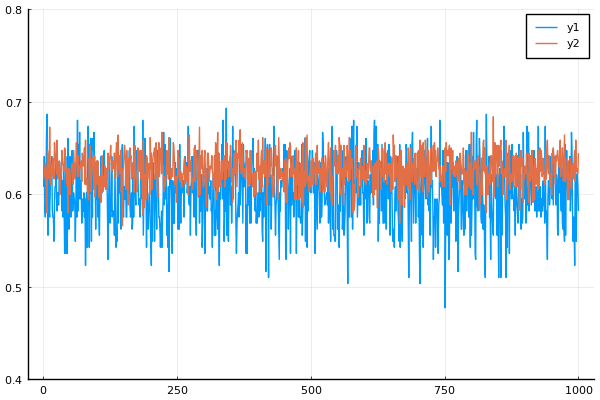

In [58]:
plot(1:1000,test_acc)
plot!(1:1000,train_acc, ylim = (0.4,0.8))